In [3]:
%matplotlib inline
import numpy as np 
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'stixgeneral'

In [4]:
# normalized radius 
R200m = 135 # kpc median virial radius R200m #
xR_min = 0.1 #  = b/R200m
xR_max = 1 # R200m 

xR_arr = np.logspace(np.log10(xR_min), np.log10(1.1), 100)
use1sig = False # False = use3sig
file_label = 'use3sig'

In [5]:
ions = ['HI', 'SiII', 'CII', 'SiIII', 'SiIV', 'CIV']

In [6]:
def ion_atomic_mass(ion): 
    ion_n_lib = {'HI': 1, 
          'SiII': 28, 
          'SiIII': 28, 
          'SiIV': 28, 
          'CII': 12, 
          'CIV': 12}
    return ion_n_lib[ion]

In [7]:
def int_mass_within_R(ion, xR_start, xR_end, logN0, k, R200m=135): 
    import astropy.constants as const
    import astropy.units as u
    # xR = r/R200m,
    ion_n = ion_atomic_mass(ion)
    
    N0 = 10**logN0 # cm-2
    constC = 2*np.pi*(ion_n*const.m_p.to(u.g).value)*((R200m*u.kpc.to(u.cm))**2) # unit of g cm2 
    
    eq_A1 = (xR_start**(k+2))/(k+2)
    eq_A2 = (xR_end**(k+2))/(k+2)
    eq_A = eq_A2 - eq_A1 
    mass_xR = constC*N0*eq_A*(u.g.to(u.Msun))
    
    return mass_xR

def calc_percentile(para_range, ndecimals=2):
    import numpy as np
    percentile = np.percentile(para_range, [16, 50, 84])
    best_val = np.around(percentile[1], decimals=ndecimals)
    sig_lo = -np.around(np.diff(percentile)[0], decimals=ndecimals)
    sig_hi = np.around(np.diff(percentile)[1], decimals=ndecimals)
    # print(best_val, sig_lo, sig_hi)

    return best_val, sig_lo, sig_hi

In [8]:
int_mass_within_R('HI', 0.1, 1, 13.1, -2.5)

49932.329464146016

In [7]:
def get_ion_chain(ion, file_label): 
    import pandas as pd 
    # get mcmc chain result and get fitted logN and k there 
    logN_labels = [r'$\alpha_N$', r'$\log N_0$']
    logN_chainfile = './data/pymc3/pymc3_{}_chain_logN_{}.feather'.format(ion, file_label)
    # print(logN_chainfile)

    chain_data = pd.read_feather(logN_chainfile)
    k_chain = np.asarray(chain_data.slope)
    logN0_chain = np.asarray(chain_data.intercept)
    return logN0_chain, k_chain

In [17]:
all_mass_result = {}
all_fmass_result = {} # normalized by total mass of each ion 
for ion in ['HI', 'CII', 'CIV', 'SiIII', 'SiIV', 'SiII']:   
    logN0_chain, k_chain = get_ion_chain(ion, file_label)
    
    # calculate total mass at R200m for all posterior distribution 
    xR_start = xR_min
    xR_end = xR_max 
    total_mass = int_mass_within_R(ion, xR_start, xR_end, logN0_chain, k_chain, R200m=R200m)
    
    # 50th percentiles and +/- from 16th and 84th 
    p50_total_mass, p50_sig_lo, p50_sig_hi = calc_percentile(total_mass)
    
    if ion in ['HI', 'CII', 'CIV']: 
        print('total mass of {} within R200m: {:.1f}{:.1f}+{:.1f} x1e4Msun'.format(ion, p50_total_mass/1e4, 
                                                                     p50_sig_lo/1e4, p50_sig_hi/1e4))
    else: 
        print('total mass of {} within R200m: {:.1f}{:.1f}+{:.1f} x1e3Msun'.format(ion, p50_total_mass/1e3, 
                                                                     p50_sig_lo/1e3, p50_sig_hi/1e3))
    # also save the p50 total mass 
    ion_mass_tb = Table.read('data/ion_cgm_mass.txt', format='ascii')
    ind_tb = np.where(ion_mass_tb['Mass']=='M({})'.format(ion))
    ind_tb_eneg = np.where(ion_mass_tb['Mass']=='M({})_e-'.format(ion))
    ind_tb_epos = np.where(ion_mass_tb['Mass']=='M({})_e+'.format(ion))
    ion_mass_tb['ThisWork'][ind_tb] = p50_total_mass
    ion_mass_tb['ThisWork'][ind_tb_eneg] = p50_sig_lo
    ion_mass_tb['ThisWork'][ind_tb_epos] = p50_sig_hi
    from astropy.io import ascii
    ascii.write(ion_mass_tb, 'data/ion_cgm_mass.txt', format='csv', overwrite=True)

    # cumulative mass for each draw of the posterior and then take p50 
    ion_mass_xR = np.zeros(xR_arr.size)
    sig_mass_lo = np.zeros(xR_arr.size)
    sig_mass_hi = np.zeros(xR_arr.size)
    
    ion_fmass_xR = np.zeros(xR_arr.size)
    sig_fmass_lo = np.zeros(xR_arr.size)
    sig_fmass_hi = np.zeros(xR_arr.size)
    
    for ix in range(len(xR_arr)): 
        xR_start = xR_min
        xR_end = xR_arr[ix]
        mass_xR = int_mass_within_R(ion, xR_start, xR_end, logN0_chain, k_chain, R200m=R200m)
        fmass_xR = mass_xR/total_mass
        ion_mass_xR[ix], sig_mass_lo[ix], sig_mass_hi[ix] = calc_percentile(mass_xR)
        ion_fmass_xR[ix], sig_fmass_lo[ix], sig_fmass_hi[ix] = calc_percentile(fmass_xR)
    
    all_mass_result[ion] = [ion_mass_xR, sig_mass_lo, sig_mass_hi]
    all_fmass_result[ion] = [ion_fmass_xR, sig_fmass_lo, sig_fmass_hi]
    #break

total mass of HI within R200m: 5.4-1.7+2.9 x1e4Msun
total mass of CII within R200m: 3.5-0.9+1.1 x1e4Msun
total mass of CIV within R200m: 2.2-0.4+0.5 x1e4Msun
total mass of SiIII within R200m: 5.6-1.1+1.3 x1e3Msun
total mass of SiIV within R200m: 7.9-2.3+2.9 x1e3Msun
total mass of SiII within R200m: 7.2-1.1+1.2 x1e3Msun


# save a latex table with the accumulative masses 

In [8]:
save_tb = {'xR': xR_arr}

kernel_size = 7
kernel = np.ones(kernel_size) / kernel_size

use_smooth = True

for kk, ion in enumerate(['HI', 'CII', 'CIV', 'SiII', 'SiIII', 'SiIV']):   
    f_low_bounds = all_fmass_result[ion][0]+all_fmass_result[ion][1]
    f_low_bounds_sm = np.convolve(f_low_bounds, kernel, mode='same')
    
    f_hi_bounds = all_fmass_result[ion][0]+all_fmass_result[ion][2]
    f_hi_bounds_sm = np.convolve(f_hi_bounds, kernel, mode='same')
    
    f_values = all_fmass_result[ion][0]
    f_values_sm = np.convolve(f_values, kernel, mode='same')
    if use_smooth == True: 
        save_tb['fmass_'+ion] = [f_values_sm, 
                        f_low_bounds_sm-f_values_sm,  # low error
                        f_hi_bounds_sm-f_values_sm] # high error 
        save_tb['mass_'+ion] = [all_mass_result[ion][0], 
                                all_mass_result[ion][1], 
                                all_mass_result[ion][2]]
    else: 
        save_tb['fmass_'+ion] = [all_fmass_result[ion][0], 
                                all_fmass_result[ion][1], 
                                all_fmass_result[ion][2]]
        save_tb['mass_'+ion] = [all_mass_result[ion][0], 
                                all_mass_result[ion][1], 
                                all_mass_result[ion][2]]
    # print(len(f_low_bounds))
    
# save to a table
from astropy.table import Table
fmass_tb = Table()
fmass_tb['xR'] = save_tb['xR']
for ion in ['HI', 'CII', 'CIV', 'SiII', 'SiIII', 'SiIV']: 
    fmass_tb['f_'+ion] = save_tb['fmass_'+ion][0]
    fmass_tb['f_'+ion+'_siglow'] = save_tb['fmass_'+ion][1]
    fmass_tb['f_'+ion+'_sighi'] = save_tb['fmass_'+ion][2]
    
    fmass_tb['M_'+ion] = save_tb['mass_'+ion][0]
    fmass_tb['M_'+ion+'_siglow'] = save_tb['mass_'+ion][1]
    fmass_tb['M_'+ion+'_sighi'] = save_tb['mass_'+ion][2]

final_tb = fmass_tb 
from astropy.io import ascii
tb_name = 'data/tb_mass_allions_{}.csv'.format(file_label)
ascii.write(fmass_tb, tb_name, format='csv', overwrite=True)

Read in table and write to a latex format

In [9]:
tb_name = 'data/tb_mass_allions_{}.csv'.format(file_label)
latex_tb = Table.read(tb_name, format='ascii')

In [10]:
xR_close = np.asarray([0.25, 0.5, 0.75])
int_ind = np.zeros(len(xR_close), dtype=int)
for i in range(len(xR_close)): 
    ind = np.argmin(np.abs(latex_tb['xR']-xR_close[i]))
    int_ind[i] = ind 
    
# latex table for paper
for ion in ['HI', 'CII', 'CIV', 'SiII', 'SiIII', 'SiIV']: 
    fmass = latex_tb['f_'+ion][int_ind]#[::2]
    fmass_lo = latex_tb['f_'+ion+'_siglow'][int_ind]#[::2]
    fmass_hi = latex_tb['f_'+ion+'_sighi'][int_ind]#[::2]
    pstr = '\\{}'.format(ion)
    
    ind_mass_r200m = np.argmin(abs(latex_tb['xR']-1))
    mass = latex_tb['M_{}'.format(ion)][ind_mass_r200m]
    mass_lo = latex_tb['M_{}_siglow'.format(ion)][ind_mass_r200m]
    mass_hi = latex_tb['M_{}_sighi'.format(ion)][ind_mass_r200m]
    
    for i in np.arange(len(fmass)):
        pstr = '%s & $%.2f_{%.2f}^{+%.2f}$'%(pstr, fmass[i], fmass_lo[i], fmass_hi[i])
    # add total mass
    int_mass = np.floor(np.log10(mass))
    mass_txt = '$%.1f^{+%.1f}_{%.1f}\\times10^%d$'%(mass/10**int_mass, mass_hi/10**int_mass,
                                                   mass_lo/10**int_mass, int_mass)
    pstr = '{} & {}'.format(pstr, mass_txt)
    print(pstr + ' \\\\')
    #print('\\hline')

\HI & $0.54_{-0.15}^{+0.14}$ & $0.81_{-0.12}^{+0.09}$ & $0.93_{-0.06}^{+0.04}$ & $5.4^{+2.9}_{-1.7}\times10^4$ \\
\CII & $0.26_{-0.07}^{+0.08}$ & $0.56_{-0.09}^{+0.09}$ & $0.80_{-0.05}^{+0.05}$ & $3.5^{+1.1}_{-0.9}\times10^4$ \\
\CIV & $0.32_{-0.07}^{+0.08}$ & $0.62_{-0.07}^{+0.07}$ & $0.83_{-0.04}^{+0.04}$ & $2.2^{+0.5}_{-0.4}\times10^4$ \\
\SiII & $0.17_{-0.03}^{+0.04}$ & $0.44_{-0.05}^{+0.05}$ & $0.72_{-0.03}^{+0.03}$ & $7.2^{+1.2}_{-1.1}\times10^3$ \\
\SiIII & $0.37_{-0.07}^{+0.08}$ & $0.67_{-0.07}^{+0.07}$ & $0.86_{-0.04}^{+0.04}$ & $5.6^{+1.3}_{-1.1}\times10^3$ \\
\SiIV & $0.22_{-0.06}^{+0.08}$ & $0.50_{-0.08}^{+0.09}$ & $0.76_{-0.05}^{+0.05}$ & $7.9^{+2.9}_{-2.3}\times10^3$ \\


# Plot the cumulative mass 

In [11]:
tb_name = 'data/tb_mass_allions_{}.csv'.format(file_label)
latex_tb = Table.read(tb_name, format='ascii')

In [12]:
colors = {'HI': 'k', 
          'CIV': 'g', 
          'SiIII': plt.cm.Blues(0.7), 
          'CII': 'r', 
          'SiIV': 'm', 
          'SiII': plt.cm.Oranges(0.6)}
ls = {'HI': '-', 
      'CIV': ':', 
      'SiIII': '--', 
      'CII': '-.', 
      'SiIV': (0, (3, 1, 1, 1, 1, 1)), 
      'SiII': (0, (3, 1, 1, 1))}

al = {'HI': 0.25,
      'CIV': 0.4,
      'SiIII': 0.3, 
      'CII': 0.3,
      'SiIV': 0.3, 
      'SiII': 0.4}

In [13]:
plt_xR_min = 0.09

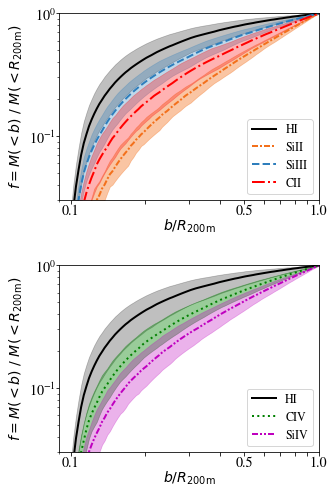

In [17]:
fs = 14

fig = plt.figure(figsize=(4.5, 7))
ax1 = fig.add_axes([0.17, 0.57, 0.8, 0.37])  ## top 
ax2 = fig.add_axes([0.17, 0.07, 0.8, 0.37])  ## bottom 

labelpad = 0.2
tickpad = 0.4

####### top panel #### 
for kk, ion in enumerate(['HI', 'SiII', 'SiIII', 'CII']):
    # error bars, smooth the edges due to mcmc percentiles 
    xR = latex_tb['xR']
    f_low_bounds = latex_tb['f_'+ion] + latex_tb['f_'+ion+'_siglow']
    f_hi_bounds = latex_tb['f_'+ion] + latex_tb['f_'+ion+'_sighi']
    f_values = latex_tb['f_'+ion]
    
    ax1.fill_between(xR, f_low_bounds, f_hi_bounds, 
                    color=colors[ion], edgecolor=colors[ion], linewidth=0.7, 
                     alpha=al[ion])
    ax1.plot(xR, f_values, label=ion, 
            color=colors[ion], lw=2, linestyle=ls[ion])

####### bottom panel ####  
for kk, ion in enumerate(['HI', 'CIV', 'SiIV']):
    xR = latex_tb['xR']
    f_low_bounds = latex_tb['f_'+ion] + latex_tb['f_'+ion+'_siglow']
    f_hi_bounds = latex_tb['f_'+ion] + latex_tb['f_'+ion+'_sighi']
    f_values = latex_tb['f_'+ion]
    
    ax2.fill_between(xR, f_low_bounds, f_hi_bounds, 
                    color=colors[ion], edgecolor=colors[ion], linewidth=0.7, 
                     alpha=al[ion])
    ax2.plot(xR, f_values, label=ion, 
            color=colors[ion], lw=2, linestyle=ls[ion])

##### 
for ax in [ax1, ax2]: 
    ax.legend(loc='lower right', fontsize=fs-2)
    ax.set_xlim(plt_xR_min, 1)
    ax.set_yscale('log')
    ax.set_xlabel(r'$b/R_{\rm 200m}$', fontsize=fs, labelpad=labelpad)
    ax.minorticks_on()
    ax.tick_params(axis='both', labelsize=fs, pad=tickpad)
    ax.set_ylim(0.03, 1.0)
    ax.set_ylabel(r'$f=M(<b)~/~M(<R_{\rm 200m})$', fontsize=fs)
    ax.set_xscale('log')
    ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticklabels(['0.1', '', '', '', '0.5', '', '', '', '', '1.0'], fontsize=fs)
    #ax.grid(ls=':', lw=0.5, color=plt.cm.Greys(0.6))
    #ax.axvline(0.1)
fig.savefig('figs/fig5_mass_rho_allions_{}.pdf'.format(file_label))